In [32]:
!pip -q install xgboost lightgbm >/dev/null 2>&1 || true

In [33]:
import os, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [34]:
CSV_PATHS = ["/content/PDB_Load_History.csv", "/mnt/data/PDB_Load_History.csv"]
TIME_COLS = ["year","month","day","hour"]
TARGET = "demand"
COVARIATES = ["temperature"]
LAGS = [1,2,3,6,12,24]
ROLLS = [3,6,12,24]
TRAIN_FRAC, VAL_FRAC = 0.70, 0.15
RANDOM_STATE = 42

In [35]:
# GRU/Seq2Seq
T_IN = 24
HORIZON = 24
GRU_EPOCHS = 200
USE_EARLY_STOPPING = False
PATIENCE = 40
BATCH = 64
LR = 1e-3
DEVICE = "cuda" if (os.environ.get("COLAB_GPU") or os.environ.get("CUDA_VISIBLE_DEVICES")) else "cpu"

In [36]:
# Load

csv_path = next((p for p in CSV_PATHS if os.path.exists(p)), None)
assert csv_path, f"CSV not found in {CSV_PATHS}"
df = pd.read_csv(csv_path)

In [37]:
# clean/sort
df = df.copy()
for c in TIME_COLS:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
if all(c in df.columns for c in TIME_COLS):
    df = df.sort_values(TIME_COLS).reset_index(drop=True)
else:
    df = df.reset_index(drop=True)

In [38]:
# Feature engineering
work = df[[TARGET] + [c for c in COVARIATES if c in df.columns]].copy()

# Lags
for lag in LAGS:
    work[f"{TARGET}_lag_{lag}"] = work[TARGET].shift(lag)
    for c in COVARIATES:
        if c in work:
            work[f"{c}_lag_{lag}"] = work[c].shift(lag)

In [39]:
# Rolling means
for w in ROLLS:
    work[f"{TARGET}_rollmean_{w}"] = work[TARGET].shift(1).rolling(w, min_periods=w//2).mean()

In [40]:
# Dropping rows
work = work.dropna().reset_index(drop=True)

In [41]:
# Split

N = len(work)
train_end = int(TRAIN_FRAC*N)
val_end = int((TRAIN_FRAC+VAL_FRAC)*N)

X_cols = [c for c in work.columns if c != TARGET]
X_all, y_all = work[X_cols].values.astype(np.float32), work[TARGET].values.astype(np.float32)

X_train, y_train = X_all[:train_end], y_all[:train_end]
X_val,   y_val   = X_all[train_end:val_end], y_all[train_end:val_end]
X_test,  y_test  = X_all[val_end:], y_all[val_end:]

In [42]:
# Scale

from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler().fit(X_train)
X_train_s = scaler_X.transform(X_train)
X_val_s   = scaler_X.transform(X_val)
X_test_s  = scaler_X.transform(X_test)

In [43]:

#  for GRU/Seq2Seq windows
series_cols = [TARGET] + [c for c in COVARIATES if c in df.columns]
series = df[series_cols].copy().reset_index(drop=True)

scaler_seq = StandardScaler().fit(series.iloc[:int(TRAIN_FRAC*len(series))])
series_scaled = pd.DataFrame(scaler_seq.transform(series), columns=series_cols)

In [44]:
# Helper to inverse only demand
def inverse_transform_demand(vec_1d):
    vec_1d = np.asarray(vec_1d).reshape(-1,1)
    zeros = np.zeros((len(vec_1d), series_scaled.shape[1]-1), dtype=np.float32)
    arr = np.concatenate([vec_1d, zeros], axis=1)
    inv = scaler_seq.inverse_transform(arr)
    return inv[:,0]


In [45]:

# ML

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


In [46]:

models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1.0, random_state=RANDOM_STATE),
    "Lasso": Lasso(alpha=1e-3, random_state=RANDOM_STATE, max_iter=10000),
    "ElasticNet": ElasticNet(alpha=1e-3, l1_ratio=0.5, random_state=RANDOM_STATE, max_iter=10000),
    "kNN": KNeighborsRegressor(n_neighbors=5),
    "SVR-linear": SVR(kernel="linear", C=1.0, epsilon=0.1),
    "SVR-rbf": SVR(kernel="rbf", C=10.0, gamma="scale", epsilon=0.1),
    "RF": RandomForestRegressor(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1),
    "GBDT": GradientBoostingRegressor(random_state=RANDOM_STATE)
}

In [47]:
#  tree boosters
try:
    from xgboost import XGBRegressor
    models["XGB"] = XGBRegressor(
        n_estimators=600, max_depth=6, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8,
        random_state=RANDOM_STATE, n_jobs=-1, tree_method="hist"
    )
except Exception as e:
    print("XGBoost not available:", e)

try:
    from lightgbm import LGBMRegressor
    models["LGBM"] = LGBMRegressor(
        n_estimators=800, learning_rate=0.05, num_leaves=64, subsample=0.8, colsample_bytree=0.8,
        random_state=RANDOM_STATE
    )
except Exception as e:
    print("LightGBM not available:", e)

In [49]:
# Fitting and predicting
ml_preds = {}
from sklearn.metrics import mean_absolute_error, mean_squared_error
def rmse(a,b): return float(np.sqrt(mean_squared_error(a,b)))

for name, m in models.items():
    m.fit(X_train_s, y_train)
    y_pred = m.predict(X_test_s)
    ml_preds[name] = y_pred.astype(np.float32)
    print(f"{name:10s}  MAE={mean_absolute_error(y_test,y_pred):.3f}  RMSE={rmse(y_test,y_pred):.3f}")

Linear      MAE=216.121  RMSE=363.531
Ridge       MAE=216.314  RMSE=363.472
Lasso       MAE=216.126  RMSE=363.529
ElasticNet  MAE=222.370  RMSE=363.034
kNN         MAE=255.536  RMSE=358.198
SVR-linear  MAE=254.761  RMSE=392.811
SVR-rbf     MAE=306.117  RMSE=536.895
RF          MAE=130.318  RMSE=225.890
GBDT        MAE=278.614  RMSE=375.781
XGB         MAE=140.217  RMSE=225.584
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3278
[LightGBM] [Info] Number of data points in the train set: 72626, number of used features: 17
[LightGBM] [Info] Start training from score 14775.190696
LGBM        MAE=131.253  RMSE=215.977


DEEP LEARNING

In [55]:
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

In [56]:
#  supervised windows for single-step next-hour(t+1)
def make_gru_windows(df_scaled, T=24):
    vals = df_scaled.values.astype(np.float32)
    d_idx = 0
    X, y = [], []
    for i in range(len(df_scaled) - T - 0):
        X.append(vals[i:i+T, :])
        y.append(vals[i+T, d_idx])
    X = np.array(X); y = np.array(y)
    return X, y

Xseq_all, yseq_all = make_gru_windows(series_scaled, T=T_IN)
S = len(Xseq_all)
tr_end = int(TRAIN_FRAC*S)
va_end = int((TRAIN_FRAC+VAL_FRAC)*S)

Xseq_tr, yseq_tr = Xseq_all[:tr_end], yseq_all[:tr_end]
Xseq_va, yseq_va = Xseq_all[tr_end:va_end], yseq_all[tr_end:va_end]
Xseq_te, yseq_te = Xseq_all[va_end:], yseq_all[va_end:]

class SeqDS(Dataset):
    def __init__(self, X,y): self.X=torch.tensor(X); self.y=torch.tensor(y)
    def __len__(self): return len(self.X)
    def __getitem__(self,i): return self.X[i], self.y[i]

tr_loader = DataLoader(SeqDS(Xseq_tr, yseq_tr), batch_size=BATCH, shuffle=False)
va_loader = DataLoader(SeqDS(Xseq_va, yseq_va), batch_size=BATCH, shuffle=False)
te_loader = DataLoader(SeqDS(Xseq_te, yseq_te), batch_size=BATCH, shuffle=False)

class GRUReg(nn.Module):
    def __init__(self, in_features, hidden=64, layers=2, dropout=0.1):
        super().__init__()
        self.gru = nn.GRU(in_features, hidden, layers, batch_first=True,
                          dropout=dropout if layers>1 else 0.0)
        self.fc = nn.Linear(hidden, 1)
    def forward(self, x):
        out,_ = self.gru(x.float().to(DEVICE))
        out = out[:,-1,:]
        return self.fc(out).squeeze(-1)

model_gru = GRUReg(in_features=Xseq_tr.shape[2]).to(DEVICE)
opt = torch.optim.Adam(model_gru.parameters(), lr=LR)
crit = nn.MSELoss()

best_state = None
best_val = np.inf
wait = 0

train_curve, val_curve = [], []

In [22]:
for epoch in range(1, GRU_EPOCHS+1):
    # train
    model_gru.train(); running=0.0
    for xb, yb in tr_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        opt.zero_grad()
        loss = crit(model_gru(xb), yb.float())
        loss.backward(); opt.step()
        running += loss.item()
    train_loss = running / max(1,len(tr_loader))
    train_curve.append(train_loss)

    # validate
    model_gru.eval(); running=0.0
    with torch.no_grad():
        for xb, yb in va_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            running += crit(model_gru(xb), yb.float()).item()
    val_loss = running / max(1,len(va_loader))
    val_curve.append(val_loss)

    if USE_EARLY_STOPPING:
        if val_loss < best_val - 1e-8:
            best_val = val_loss
            best_state = {k:v.detach().cpu().clone() for k,v in model_gru.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= PATIENCE:
                print(f"[GRU] Early stopping at {epoch}")
                break

    if epoch % 10 == 0 or epoch == 1:
        print(f"[GRU] Epoch {epoch:03d}  Train {train_loss:.6f}  Val {val_loss:.6f}")

if USE_EARLY_STOPPING and best_state is not None:
    model_gru.load_state_dict(best_state)

[GRU] Epoch 001  Train 0.004442  Val 0.004978
[GRU] Epoch 010  Train 0.004055  Val 0.005664
[GRU] Epoch 020  Train 0.003655  Val 0.005459
[GRU] Epoch 030  Train 0.003249  Val 0.005694
[GRU] Epoch 040  Train 0.003376  Val 0.005404
[GRU] Epoch 050  Train 0.002860  Val 0.004386
[GRU] Epoch 060  Train 0.002890  Val 0.003885
[GRU] Epoch 070  Train 0.002684  Val 0.004526
[GRU] Epoch 080  Train 0.002875  Val 0.005403
[GRU] Epoch 090  Train 0.002634  Val 0.003552
[GRU] Epoch 100  Train 0.002883  Val 0.004912
[GRU] Epoch 110  Train 0.002552  Val 0.004176
[GRU] Epoch 120  Train 0.002441  Val 0.004012
[GRU] Epoch 130  Train 0.002663  Val 0.005834
[GRU] Epoch 140  Train 0.002329  Val 0.004432
[GRU] Epoch 150  Train 0.001996  Val 0.004939
[GRU] Epoch 160  Train 0.002397  Val 0.003837
[GRU] Epoch 170  Train 0.002813  Val 0.005593
[GRU] Epoch 180  Train 0.002264  Val 0.003297
[GRU] Epoch 190  Train 0.002081  Val 0.003755
[GRU] Epoch 200  Train 0.003078  Val 0.004490


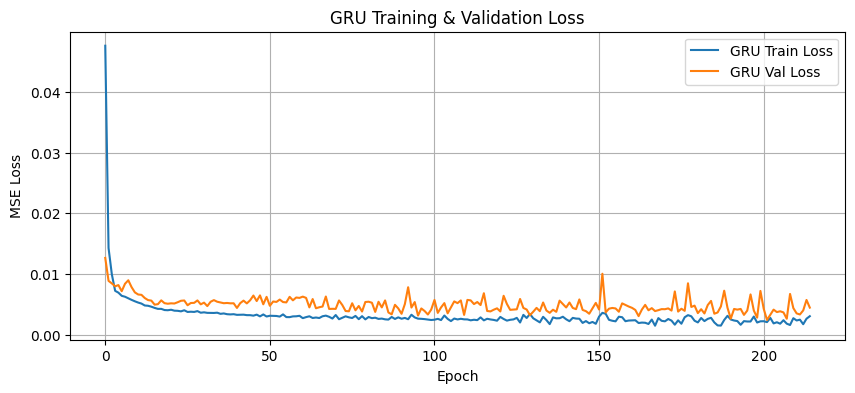

In [23]:
# Loss curves
plt.figure(figsize=(10,4))
plt.plot(train_curve, label="GRU Train Loss")
plt.plot(val_curve, label="GRU Val Loss")
plt.title("GRU Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend(); plt.grid(True); plt.show()


In [65]:
# GRU predictions
model_gru.eval()
preds_g, trues_g = [], []
with torch.no_grad():
    for xb, yb in te_loader:
        xb = xb.to(DEVICE)
        out = model_gru(xb).cpu().numpy()
        preds_g.append(out); trues_g.append(yb.numpy())
preds_g = np.concatenate(preds_g); trues_g = np.concatenate(trues_g)

preds_g_inv = inverse_transform_demand(preds_g)
trues_g_inv = inverse_transform_demand(trues_g)

print(f"GRU  MAE={np.mean(np.abs(preds_g_inv-trues_g_inv)):.3f}  "
      f"RMSE={np.sqrt(np.mean((preds_g_inv-trues_g_inv)**2)):.3f}")

GRU  MAE=2179.548  RMSE=2804.188


 Deep Learning — Seq2Seq Encoder-Decoder (multi-step)

In [58]:
class Encoder(nn.Module):
    def __init__(self, in_features, hidden=128, layers=2, dropout=0.1):
        super().__init__()
        self.gru = nn.GRU(in_features, hidden, layers, batch_first=True,
                          dropout=dropout if layers>1 else 0.0)
    def forward(self, x):
        _, h = self.gru(x.float().to(DEVICE))
        return h

class Decoder(nn.Module):
    def __init__(self, hidden=128, out_size=1, layers=2, dropout=0.1):
        super().__init__()
        self.gru = nn.GRU(out_size, hidden, layers, batch_first=True,
                          dropout=dropout if layers>1 else 0.0)
        self.fc = nn.Linear(hidden, out_size)
    def forward(self, y_in, h):
        out, h_new = self.gru(y_in, h)
        y_hat = self.fc(out[:,-1,:]).unsqueeze(1)
        return y_hat, h_new

class Seq2Seq(nn.Module):
    def __init__(self, in_features, hidden=128, layers=2, dropout=0.1, horizon=24):
        super().__init__()
        self.enc = Encoder(in_features, hidden, layers, dropout)
        self.dec = Decoder(hidden, out_size=1, layers=layers, dropout=dropout)
        self.horizon = horizon
    def forward(self, src, teacher=None, tf_ratio=0.5):
        B = src.size(0)
        h = self.enc(src)

        y_t = src[:,-1,[0]].unsqueeze(1)
        outs = []
        for t in range(self.horizon):
            y_hat, h = self.dec(y_t, h)
            outs.append(y_hat.squeeze(1))
            if self.training and (teacher is not None) and (np.random.rand() < tf_ratio):
                y_t = teacher[:,t].unsqueeze(-1).unsqueeze(1)
            else:
                y_t = y_hat.detach()
        return torch.cat(outs, dim=1)

In [59]:
# windows for seq2seq: (X: (T, F), Y: (H,))
def make_seq2seq_windows(df_scaled, T=24, H=24):
    vals = df_scaled.values.astype(np.float32)
    d_idx = 0
    X, Y = [], []
    for i in range(len(df_scaled) - T - H + 1):
        X.append(vals[i:i+T,:])
        Y.append(vals[i+T:i+T+H, d_idx])
    return np.array(X), np.array(Y)

XH_all, YH_all = make_seq2seq_windows(series_scaled, T=T_IN, H=HORIZON)
S2 = len(XH_all)
tr2_end = int(TRAIN_FRAC*S2)
va2_end = int((TRAIN_FRAC+VAL_FRAC)*S2)

XH_tr, YH_tr = XH_all[:tr2_end], YH_all[:tr2_end]
XH_va, YH_va = XH_all[tr2_end:va2_end], YH_all[tr2_end:va2_end]
XH_te, YH_te = XH_all[va2_end:], YH_all[va2_end:]

tr2_loader = DataLoader(SeqDS(XH_tr, YH_tr), batch_size=BATCH, shuffle=False)
va2_loader = DataLoader(SeqDS(XH_va, YH_va), batch_size=BATCH, shuffle=False)
te2_loader = DataLoader(SeqDS(XH_te, YH_te), batch_size=BATCH, shuffle=False)

model_s2s = Seq2Seq(in_features=XH_tr.shape[2], hidden=128, layers=2, dropout=0.1, horizon=HORIZON).to(DEVICE)
opt2 = torch.optim.Adam(model_s2s.parameters(), lr=LR)
crit2 = nn.MSELoss()

train_curve_s2s, val_curve_s2s = [], []
best_state2, best_val2, wait2 = None, np.inf, 0


In [60]:
import math
import torch


In [61]:
# 1) Move entire datasets to the device ONCE (same order as before; no shuffle)
XH_tr_t = torch.tensor(XH_tr, dtype=torch.float32, device=DEVICE)
YH_tr_t = torch.tensor(YH_tr, dtype=torch.float32, device=DEVICE)
XH_va_t = torch.tensor(XH_va, dtype=torch.float32, device=DEVICE)
YH_va_t = torch.tensor(YH_va, dtype=torch.float32, device=DEVICE)


In [63]:
# (Test moved later before inference)
torch.backends.cudnn.benchmark = True  # speed up GRU kernels for fixed input sizes

def epoch_pass(model, X, Y, batch_size, optimizer=None, teacher_forcing=0.5):
    """
    If optimizer is None -> validation mode (no grad).
    Else -> training mode.
    Returns mean loss over all batches.
    """
    crit = crit2  # use your existing loss
    H = X.size(0)
    n_batches = (H + batch_size - 1) // batch_size

    if optimizer is None:
        model.eval()
        total = 0.0
        with torch.no_grad():
            for b in range(n_batches):
                s = b * batch_size
                e = min(s + batch_size, H)
                out = model(X[s:e], teacher=None, tf_ratio=0.0)  # no teacher in val
                loss = crit(out, Y[s:e])
                total += loss.item()
        return total / max(1, n_batches)
    else:
        model.train()
        total = 0.0
        for b in range(n_batches):
            s = b * batch_size
            e = min(s + batch_size, H)
            optimizer.zero_grad(set_to_none=True)
            out = model(X[s:e], teacher=Y[s:e], tf_ratio=teacher_forcing)
            loss = crit(out, Y[s:e])
            loss.backward()
            optimizer.step()
            total += loss.item()
        return total / max(1, n_batches)

In [24]:
# ---- TRAINING LOOP (same logic as before; just faster IO) ----
train_curve_s2s, val_curve_s2s = [], []
best_state2, best_val2, wait2 = None, float("inf"), 0

for epoch in range(1, GRU_EPOCHS + 1):
    train_loss = epoch_pass(model_s2s, XH_tr_t, YH_tr_t, BATCH, optimizer=opt2, teacher_forcing=0.5)
    val_loss   = epoch_pass(model_s2s, XH_va_t, YH_va_t, BATCH, optimizer=None, teacher_forcing=0.0)

    train_curve_s2s.append(train_loss)
    val_curve_s2s.append(val_loss)

    if USE_EARLY_STOPPING:
        if val_loss < best_val2 - 1e-8:
            best_val2 = val_loss
            best_state2 = {k: v.detach().cpu().clone() for k, v in model_s2s.state_dict().items()}
            wait2 = 0
        else:
            wait2 += 1
            if wait2 >= PATIENCE:
                print(f"[Seq2Seq] Early stopping at {epoch}")
                break

    if epoch % 10 == 0 or epoch == 1:
        print(f"[Seq2Seq] Epoch {epoch:03d}  Train {train_loss:.6f}  Val {val_loss:.6f}")

if USE_EARLY_STOPPING and best_state2 is not None:
    model_s2s.load_state_dict(best_state2)


[Seq2Seq] Epoch 001  Train 0.012795  Val 0.138999
[Seq2Seq] Epoch 010  Train 0.010389  Val 0.165552
[Seq2Seq] Epoch 020  Train 0.009049  Val 0.122480
[Seq2Seq] Epoch 030  Train 0.008137  Val 0.145445
[Seq2Seq] Epoch 040  Train 0.007916  Val 0.153781
[Seq2Seq] Epoch 050  Train 0.008007  Val 0.117529
[Seq2Seq] Epoch 060  Train 0.008355  Val 0.148485
[Seq2Seq] Epoch 070  Train 0.007507  Val 0.170965
[Seq2Seq] Epoch 080  Train 0.007620  Val 0.119360
[Seq2Seq] Epoch 090  Train 0.007276  Val 0.127662
[Seq2Seq] Epoch 100  Train 0.007865  Val 0.122337
[Seq2Seq] Epoch 110  Train 0.006985  Val 0.127631
[Seq2Seq] Epoch 120  Train 0.007005  Val 0.107205
[Seq2Seq] Epoch 130  Train 0.006651  Val 0.106848
[Seq2Seq] Epoch 140  Train 0.005359  Val 0.129298
[Seq2Seq] Epoch 150  Train 0.005678  Val 0.108471
[Seq2Seq] Epoch 160  Train 0.005118  Val 0.109837
[Seq2Seq] Epoch 170  Train 0.006083  Val 0.104812
[Seq2Seq] Epoch 180  Train 0.005631  Val 0.119759
[Seq2Seq] Epoch 190  Train 0.005311  Val 0.091103


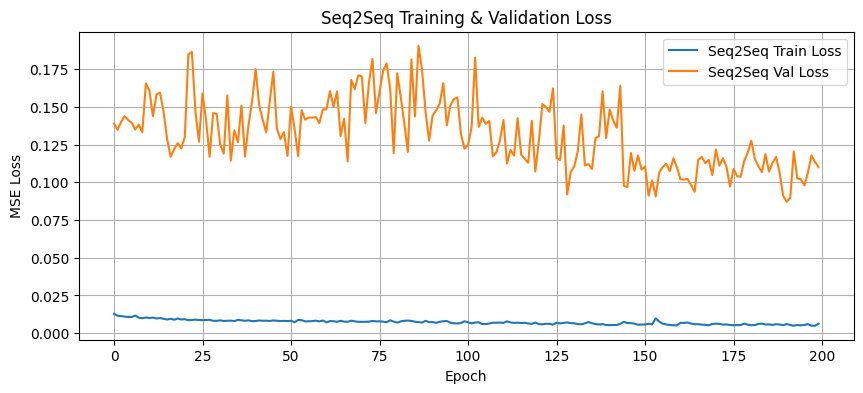

In [25]:
# Loss curves
plt.figure(figsize=(10,4))
plt.plot(train_curve_s2s, label="Seq2Seq Train Loss")
plt.plot(val_curve_s2s, label="Seq2Seq Val Loss")
plt.title("Seq2Seq Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend(); plt.grid(True); plt.show()

In [29]:
# Inference
model_s2s.eval()
preds_s2s, trues_s2s = [], []
with torch.no_grad():
    for xb, yb in te2_loader:
        xb = xb.to(DEVICE)
        out = model_s2s(xb, teacher=None, tf_ratio=0.0).cpu().numpy()  # (B,H)
        preds_s2s.append(out); trues_s2s.append(yb.numpy())
preds_s2s = np.vstack(preds_s2s)  # (N,H)
trues_s2s = np.vstack(trues_s2s)

In [30]:
# Inverse-transform demand for each step
preds_s2s_inv = np.column_stack([inverse_transform_demand(preds_s2s[:,h]) for h in range(HORIZON)])
trues_s2s_inv = np.column_stack([inverse_transform_demand(trues_s2s[:,h]) for h in range(HORIZON)])

mae_s2s = float(np.mean(np.abs(preds_s2s_inv - trues_s2s_inv)))
rmse_s2s = float(np.sqrt(np.mean((preds_s2s_inv - trues_s2s_inv)**2)))
print(f"Seq2Seq Overall  MAE={mae_s2s:.3f}  RMSE={rmse_s2s:.3f}")


Seq2Seq Overall  MAE=596.187  RMSE=921.890


In [50]:

# ground truth vs predictions for ML
ml_names = list(ml_preds.keys())
L_ml = min(len(y_test), *[len(ml_preds[n]) for n in ml_names])

gt_ml = y_test[:L_ml]
ml_series = {n: ml_preds[n][:L_ml] for n in ml_names}


In [66]:

# 2) For GRU (single-step): already same index as its own test; align by length
L_gru = min(len(trues_g_inv), len(preds_g_inv))
gt_gru = trues_g_inv[:L_gru]
gru_pred = preds_g_inv[:L_gru]


In [51]:
#  For Seq2Seq: plot the first step ahead vs true for comparability
gt_s2s_1 = trues_s2s_inv[:,0]
pred_s2s_1 = preds_s2s_inv[:,0]
L_s2s = min(len(gt_s2s_1), len(pred_s2s_1))
gt_s2s_1 = gt_s2s_1[:L_s2s]
pred_s2s_1 = pred_s2s_1[:L_s2s]


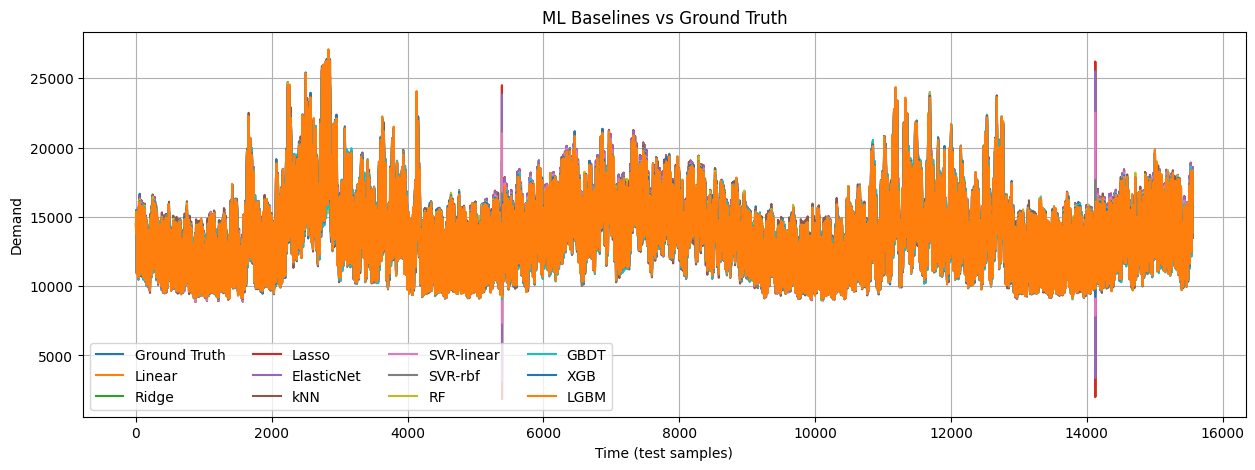

In [52]:
#  ML models vs GT
plt.figure(figsize=(15,5))
plt.plot(gt_ml, label="Ground Truth")
for n in ml_names:
    plt.plot(ml_series[n], label=n)
plt.title("ML Baselines vs Ground Truth")
plt.xlabel("Time (test samples)"); plt.ylabel("Demand")
plt.legend(ncol=4); plt.grid(True); plt.show()

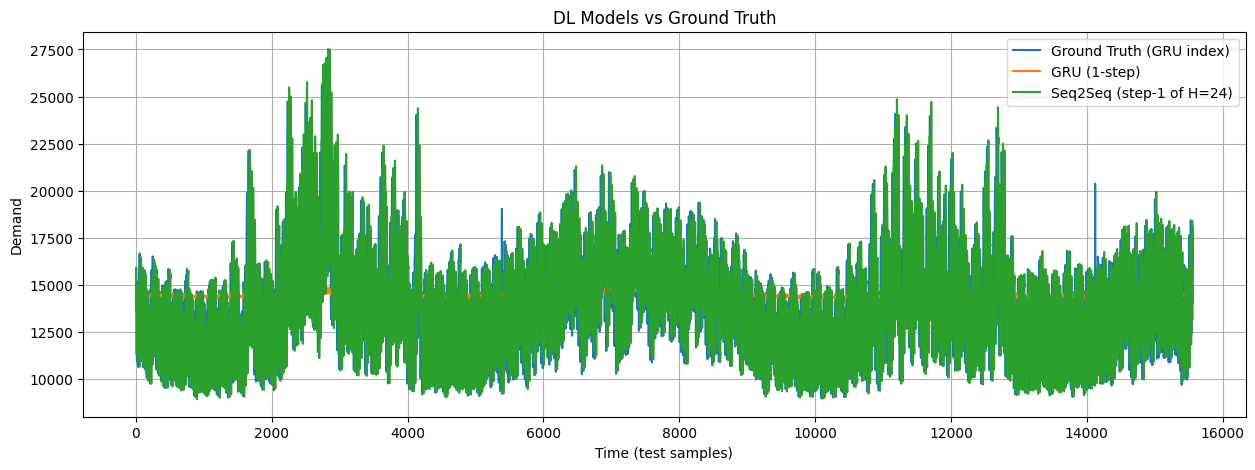

In [67]:
# DL models vs GT (GRU 1-step, Seq2Seq step-1)
plt.figure(figsize=(15,5))
plt.plot(gt_gru, label="Ground Truth (GRU index)")
plt.plot(gru_pred, label="GRU (1-step)")
plt.plot(pred_s2s_1, label=f"Seq2Seq (step-1 of H={HORIZON})")
plt.title("DL Models vs Ground Truth")
plt.xlabel("Time (test samples)"); plt.ylabel("Demand")
plt.legend(); plt.grid(True); plt.show()